In [5]:
!pip install opencv-python
!pip install pillow

    100% |████████████████████████████████| 24.9MB 54kB/s  eta 0:00:01  7% |██▌                             | 1.9MB 50.9MB/s eta 0:00:01
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
!pip install tensorflow-gpu
!pip install keras

    100% |████████████████████████████████| 256.2MB 5.0kB/s eta 0:00:01   34% |███████████                     | 88.8MB 60.2MB/s eta 0:00:03
    100% |████████████████████████████████| 7.5MB 166kB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 9.5MB/s eta 0:00:01
    100% |████████████████████████████████| 3.1MB 417kB/s eta 0:00:01
    100% |████████████████████████████████| 890kB 1.4MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 9.8MB/s eta 0:00:01
  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/de/f7/bf/1bcac7bf30549e6a4957382e2ecab04c88e513117207067b03
  Running setup.py bdist_wheel for gast ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8e/fa/d6/77dd17d18ea23fd7b860e02623d27c1be451521af40dd4a13e
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/76/f7/0c/88796d7212af59bb2f496b12267e0605f205170781e9b86479
  Runnin

In [12]:
%%time
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score,log_loss, confusion_matrix, auc, roc_auc_score, roc_curve
import keras
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf
import pickle
%matplotlib inline
from PIL import Image
import itertools

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 4.71 ms


## Basic functions for plotting ROC cuves and Confusion Matrixes

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="gold" if cm[i, j] > thresh else "lightgreen")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def plot_roc(y_test, probs):
#     probas = model.predict_proba(X_test)
#     probs = probas[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    # method I: plt
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr,
             color = 'b',
             label = 'AUC = {0}'.format(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Converting Data into python numpy arrays, skip to 'Loading Pickle File's' if you have pickle files

In [2]:
# ../input/
PATH = os.path.abspath(os.path.join('.'))

# ../input/sample/images/
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")

# ../input/sample/images/*.png
imagesDir = glob(os.path.join(SOURCE_IMAGES, "*.png"))

In [3]:
imagesDir[2]

'c:\\users\\rdame\\documents\\capstone\\sample\\images\\00000017_001.png'

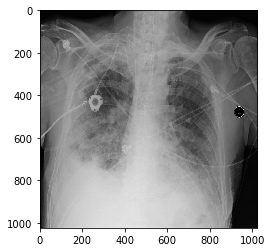

In [4]:
cvimage = cv2.imread(imagesDir[10],1)
plt.imshow(cvimage) #cvimage is a numpy array

In [6]:
#converts all sample images to grayscale 0, then normalizes them, and stores in an numpy array
%time Xrays256 = np.array([cv2.resize(cv2.imread(img,0), (256, 256), interpolation = cv2.INTER_AREA)/255 for img in imagesDir[:]])

Wall time: 1min 14s


In [7]:
Xrays256.shape

(5606, 256, 256)

In [9]:
# Xrays256 = Xrays256.flatten().reshape(5606, 256*256)

In [8]:
# ##not yet
with open('256Xrays.pickle', 'wb') as container:
    pickle.dump(Xrays256, container, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
#next three cells create and encode labels in proper shape
sample_labels = pd.read_csv('sample_labels.csv')
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax',
                  'Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration',
                  'Fibrosis','Pneumonia', 'No Finding']
for pathology in pathology_list:
    sample_labels[pathology] = sample_labels['Finding Labels'].map(lambda x: 1 if pathology in x else 0)

In [10]:
sample_labels.iloc[:,-15:]

,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Finding
0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [11]:
binary_labels = sample_labels.iloc[:,-1].values.reshape(-1,1)
multiclass_labels = sample_labels.iloc[:,-15:].values

binary_labels.shape, multiclass_labels.shape

((5606, 1), (5606, 15))

In [12]:
binary_labels = 1-binary_labels

In [151]:
with open('binary_labels.pickle', 'wb') as container:
    pickle.dump(binary_labels, container, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('multiclass_labels.pickle', 'wb') as container:
    pickle.dump(multiclass_labels, container, protocol=pickle.HIGHEST_PROTOCOL)

## Getting Data and Labels from prestored pickle files

In [2]:
# gray scaled to 128 x 128, 256 x 256 change filename to 256Xrays.pickle
with open('grayXrays.pickle', "rb") as input_file:
    xrays = pickle.load(input_file)

In [3]:
with open('binary_labels.pickle', 'rb') as input_file:
    binary_labels = pickle.load(input_file)

In [4]:
binary_labels[0]

array([1], dtype=int64)

In [5]:
xrays.shape
# plt.imshow(Xrays256[100])

(5606, 128, 128)

## train test splitting, and creating batch indices

In [7]:
#using binary labels, so were gonna see if we can predict an abnormality or not!

X_train, X_test, y_train, y_test = train_test_split(xrays, binary_labels, test_size = .2)

In [8]:
#to conserve memory
del xrays

In [16]:
int(np.ceil(len(X_train)/64)) #32 batches

71

In [17]:
#make this a fx with above, def fx(num_batches)

from sklearn.model_selection import train_test_split, KFold

kf = KFold(n_splits=71, shuffle=True, random_state=42)

batches = [train for test, train  in kf.split(X_train, y_train)]
batches[0].shape

(64,)

In [18]:
1122/64

17.53125

In [19]:
kf = KFold(n_splits=18, shuffle=True, random_state=42)

test_batches = [t_batch for _, t_batch  in kf.split(X_test, y_test)]
test_batches[0]

array([  44,   51,   56,   70,   86,   88,   96,  156,  158,  178,  208,
        247,  270,  289,  298,  309,  331,  333,  354,  355,  381,  388,
        432,  477,  478,  485,  494,  522,  526,  534,  545,  548,  599,
        622,  630,  631,  667,  694,  716,  736,  756,  759,  777,  787,
        793,  803,  823,  824,  843,  855,  909,  912,  963,  970,  991,
        997, 1000, 1008, 1055, 1063, 1079, 1086, 1115])

In [20]:
X_train.shape

(4484, 256, 256)

## tensorflow very very simple CNN

In [21]:
#graph
tf.reset_default_graph()
X = tf.placeholder(dtype = tf.float32,
                   shape = (None, 256, 256), #remember i resized image to 128x128 grayscale using .reshape(-1,128,128,1)
                   name = 'X')

y = tf.placeholder(dtype = tf.float32,
                   shape = (None),
                   name = 'y')

# Input Layer
input_layer = tf.reshape(X, [-1, 128, 128, 1])
                                                                        
# Convolutional Layer #1
out = tf.layers.conv2d(inputs=input_layer,filters=4,
                         kernel_size=[2, 2],
                         padding="same",
                         activation=tf.nn.relu)
# Pooling Layer #1
out = tf.layers.max_pooling2d(inputs=out,
                                pool_size=[2, 2],##64 x 64, strides = 2 so our image is compressed from 128 --> 64
                                    strides=2)
# 2nd Convolutional Layer #2 and Pooling Layer #2
out = tf.layers.conv2d(inputs=out,filters=8,
                         kernel_size=[2, 2],
                         padding="same",
                         activation=tf.nn.relu)
# 2nd Pooling Layer    
out = tf.layers.max_pooling2d(inputs=out,
                                pool_size=[2, 2],#64x64 14 -- >7
                                strides=2)
# 3rd Convolutional Layer
out = tf.layers.conv2d(inputs=out,filters=8,
                         kernel_size=[2, 2],
                         padding="same",
                         activation=tf.nn.relu)
# Dense, dropout, dense Layer
out = tf.reshape(out, [-1, 64 * 64 * 8]) #FLATTEN LAYER
dense = tf.layers.dense(inputs=out, units=100, activation=tf.nn.relu) #FIRST DENSE LAYER
dropout = tf.layers.dropout(inputs=dense,
                            rate=0.2)#40% to zero DROPOUT LAYER
dense2 = tf.layers.dense(inputs=dropout, units=100, activation=tf.nn.relu) #SECOND DENSE LAYER

# Logits Layer
y_hat = tf.layers.dense(inputs=dense2, units=1, #will need to change this once I have more labels/diseases
                        activation = tf.nn.sigmoid)

loss = tf.losses.log_loss(y, y_hat)#gives the loss 

optimizer = tf.train.AdamOptimizer(0.001)

training_op = optimizer.minimize(loss)#optimizes the loss fx with adam gradient descent

saver = tf.train.Saver()

In [22]:
384/64, X_test.shape

(6.0, (1122, 256, 256))

In [23]:
%%time
#execution phase

init = tf.global_variables_initializer()

test_err = []
train_err = []
pred = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(35): #maybe add some minibatches so it converges faster
        for count, batch in enumerate(batches):
            X_batch = X_train[batch]
            y_batch = y_train[batch]
            sess.run(training_op,
                     feed_dict={X:X_batch, y:y_batch})
            print('epoch:{0}, batch{1}'.format(epoch, count), end='\r')
            
        train_loss = sess.run(loss, feed_dict={X:X_batch, y:y_batch})
        train_err.append(train_loss)
#         test_loss = sess.run(loss, feed_dict={X:X_test, y:y_test})
        
#         test_err.append(test_loss)
       
        print('epoch', epoch, train_loss) #no need for the 'epoch+1', just epoch will suffice
        
    saver.save(sess,'./128Xrays.ckpt')
    
    for batch in test_batches:
        pred.append(sess.run(y_hat, feed_dict={X:X_test[batch]}))

epoch 0 0.67738307
epoch 1 0.6629052
epoch 2 0.6574151
epoch 3 0.65459085
epoch 4 0.65331596
epoch 5 0.6415554
epoch 6 0.627098
epoch 7 0.6050882
epoch 8 0.5868352
epoch 9 0.56088585
epoch 10 0.5581034
epoch 11 0.58142877
epoch 12 0.44641623
epoch 13 0.40870973
epoch 14 0.3307227
epoch 15 0.33212578
epoch 16 0.23975305
epoch 17 0.20491189
epoch 18 0.20699169
epoch 19 0.16715825
epoch 20 0.10764311
epoch 21 0.1438417
epoch 22 0.10114137
epoch 23 0.12105498
epoch 24 0.06916024
epoch 25 0.10490422
epoch 26 0.083808966
epoch 27 0.019700876
epoch 28 0.013885878
epoch 29 0.005959278
epoch 30 0.012703353
epoch 31 0.0036400275
epoch 32 0.0023366127
epoch 33 0.006601546
epoch 34 0.008569528
Wall time: 17min 49s


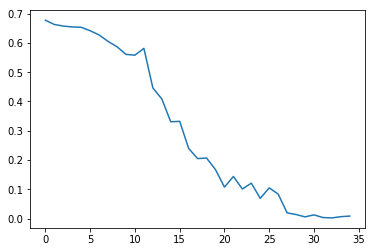

In [24]:
plt.plot(train_err)

In [25]:
predictions = [result for p in pred for result in p ]


In [26]:
predictions[-1]

array([0.06901331], dtype=float32)

In [27]:
from sklearn.metrics import accuracy_score,log_loss #ytrue ypred

log_loss(y_test, [[p[0],1-p[0]] for p in predictions])


3.8044458698261656

In [28]:
np.round([p[0] for p in predictions])

array([1., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [29]:
confusion_matrix(y_test, np.round([p[0] for p in predictions]))

array([[430, 206],
       [329, 157]], dtype=int64)

Confusion matrix, without normalization
[[430 206]
 [329 157]]
Normalized confusion matrix
[[0.68 0.32]
 [0.68 0.32]]


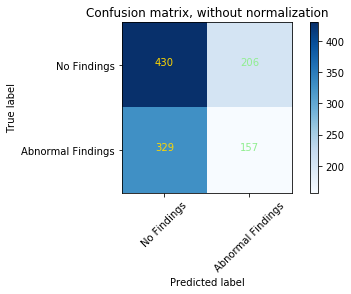

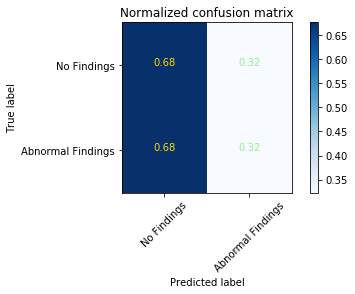

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="gold" if cm[i, j] > thresh else "lightgreen")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in predictions]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
def plot_roc(y_test, probs):
#     probas = model.predict_proba(X_test)
#     probs = probas[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    # method I: plt
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr,
             color = 'b',
             label = 'AUC = {0}'.format(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

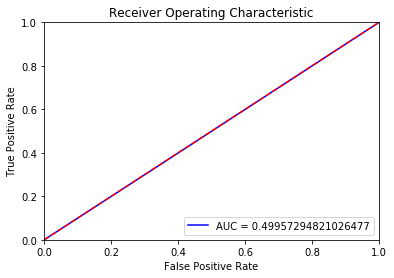

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
plot_roc(y_test, np.round([p[0] for p in predictions]))

In [132]:
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])


array([[0, 2],
       [1, 1]], dtype=int64)

In [133]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
(tn, fp, fn, tp)

(0, 2, 1, 1)

In [64]:
[[p[0],1-p[0]] for p in predictions]

[[0.9998529, 0.00014710426330566406],
 [0.8813702, 0.1186298131942749],
 [0.6209439, 0.37905609607696533],
 [0.8541119, 0.145888090133667],
 [0.9855254, 0.014474570751190186],
 [0.9994217, 0.0005782842636108398],
 [0.8626239, 0.13737612962722778],
 [0.45166594, 0.5483340620994568],
 [0.9061857, 0.09381431341171265],
 [0.63909686, 0.36090314388275146],
 [0.0001224649, 0.9998775350977667],
 [0.9620355, 0.03796452283859253],
 [0.34262937, 0.6573706269264221],
 [5.827145e-06, 0.9999941728551676],
 [0.9571275, 0.042872488498687744],
 [0.28865063, 0.711349368095398],
 [1.0, 0.0],
 [0.99080515, 0.00919485092163086],
 [0.64419186, 0.3558081388473511],
 [0.81815845, 0.18184155225753784],
 [0.28865063, 0.711349368095398],
 [0.66577387, 0.334226131439209],
 [0.96405536, 0.03594464063644409],
 [0.28865063, 0.711349368095398],
 [0.29418918, 0.7058108150959015],
 [0.4474615, 0.5525385141372681],
 [0.9996935, 0.0003064870834350586],
 [0.0016967859, 0.9983032140880823],
 [0.8564084, 0.1435915827751159

In [12]:
X_train.shape[1:]

(128, 128)

In [15]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  (128,128,1), 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(1, activation = 'sigmoid'))

multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 3,753,601
Trainable params: 3,731,713
Non-trainable params: 21,888
_____________________________________________________________

In [20]:
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [21]:
X_train.shape

(4484, 128, 128, 1)

In [22]:
multi_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=10,
                        verbose = 1)

Epoch 1/10
4484/4484 [==============================] - 125s 28ms/step - loss: 1.0293 - binary_accuracy: 0.5424 - mean_absolute_error: 0.4715

In [25]:
pred_y = multi_disease_model.predict(X_test, batch_size = 32, verbose = True)

1122/1122 [==============================] - 11s 10ms/step

In [27]:
score = multi_disease_model.evaluate(X_test, y_test, verbose=0)
labels = multi_disease_model.metrics_names

In [28]:
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 0.7527744357811151
binary_accuracy: 0.5365418894830659


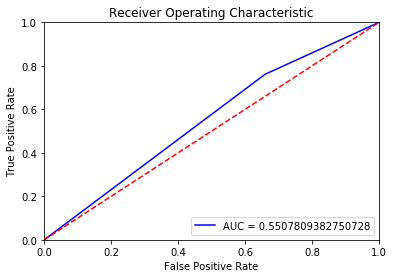

In [38]:
##only trained on 10 epochs. 
plot_roc(y_test, np.round([p[0] for p in pred_y]))

Confusion matrix, without normalization
[[204 395]
 [125 398]]
Normalized confusion matrix
[[0.34 0.66]
 [0.24 0.76]]


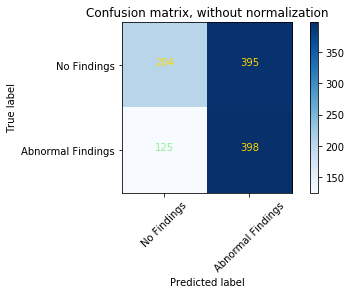

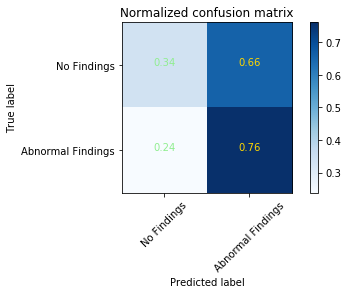

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [43]:
# Lets train on more epochs, lets do 35

base_mobilenet_model = MobileNet(input_shape =  (128,128,1), 
                                 include_top = False, weights = None)
single_disease_model = Sequential()
single_disease_model.add(base_mobilenet_model)
single_disease_model.add(GlobalAveragePooling2D())
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(512))
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(1, activation = 'sigmoid'))

single_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
single_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 3,753,601
Trainable params: 3,731,713
Non-trainable params: 21,888
_____________________________________________________________

In [46]:
single_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=30,
                        verbose = 1)

Epoch 1/30
4484/4484 [==============================] - 114s 25ms/step - loss: 1.0392 - binary_accuracy: 0.5368 - mean_absolute_error: 0.4773

In [47]:
pred_y = multi_disease_model.predict(X_test, batch_size = 32, verbose = True)
score = multi_disease_model.evaluate(X_test, y_test, verbose=0)
labels = multi_disease_model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1122/1122 [==============================] - 11s 10ms/step

Confusion matrix, without normalization
[[329 270]
 [223 300]]
Normalized confusion matrix
[[0.55 0.45]
 [0.43 0.57]]


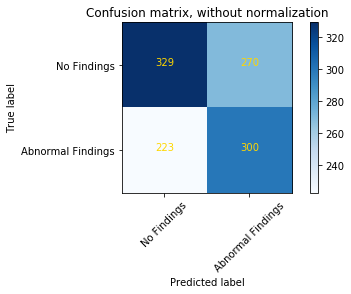

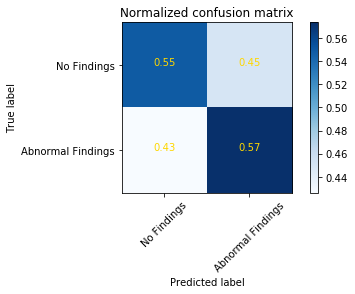

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

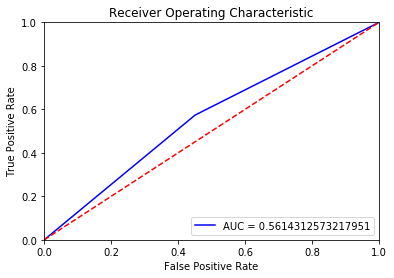

In [49]:
plot_roc(y_test, np.round([p[0] for p in pred_y]))

## lets try in on 256 x 256 grayscale images

In [15]:
with open('256Xrays.pickle', "rb") as input_file:
    xrays = pickle.load(input_file)
    
with open('binary_labels.pickle', 'rb') as input_file:
    binary_labels = pickle.load(input_file)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(xrays, binary_labels, test_size = .2)

In [17]:
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)

In [22]:
base_vgg_model = VGG16(input_shape=(256,256,1),
                            include_top=False,
                            weights = None)

#                         MobileNet(input_shape =  (128,128,1), 
#                                  include_top = False, weights = None)
    
single_disease_model = Sequential()
single_disease_model.add(base_vgg_model)
single_disease_model.add(GlobalAveragePooling2D())
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(512))
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(1, activation = 'sigmoid'))

adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

single_disease_model.compile(optimizer = adam, loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
single_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14713536  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 14,976,705
Trainable params: 14,976,705
Non-trainable params: 0
________________________________________________________________

In [23]:
single_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=40,
                        verbose = 1)

Epoch 1/40
4484/4484 [==============================] - 145s 32ms/step - loss: 8.5958 - binary_accuracy: 0.4579 - mean_absolute_error: 0.5424
Epoch 2/40
4484/4484 [==============================] - 143s 32ms/step - loss: 8.6510 - binary_accuracy: 0.4574 - mean_absolute_error: 0.5426
Epoch 3/40
4484/4484 [==============================] - 143s 32ms/step - loss: 8.7082 - binary_accuracy: 0.4538 - mean_absolute_error: 0.5462
Epoch 4/40
4484/4484 [==============================] - 143s 32ms/step - loss: 8.6616 - binary_accuracy: 0.4567 - mean_absolute_error: 0.5433
Epoch 5/40
4484/4484 [==============================] - 143s 32ms/step - loss: 8.6224 - binary_accuracy: 0.4592 - mean_absolute_error: 0.5408
Epoch 6/40
4484/4484 [==============================] - 143s 32ms/step - loss: 8.6759 - binary_accuracy: 0.4558 - mean_absolute_error: 0.5442
Epoch 7/40
4484/4484 [==============================] - 143s 32ms/step - loss: 8.6904 - binary_accuracy: 0.4550 - mean_absolute_error: 0.5450
Epoch 

KeyboardInterrupt: 

In [24]:
base_inc_model = InceptionV3(input_shape=(256,256,1),
                            include_top=False,
                            weights=None)

    
single_disease_model = Sequential()
single_disease_model.add(base_inc_model)
single_disease_model.add(GlobalAveragePooling2D())
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(512))
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(1, activation = 'sigmoid'))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

single_disease_model.compile(optimizer = adam, loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
single_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802208  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 22,851,809
Trainable params: 22,817,377
Non-trainable params: 34,432
___________________________________________________________

In [25]:
single_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=40,
                        verbose = 1)

Epoch 1/40
4484/4484 [==============================] - 147s 33ms/step - loss: 1.1682 - binary_accuracy: 0.5076 - mean_absolute_error: 0.4962
Epoch 2/40
4484/4484 [==============================] - 123s 27ms/step - loss: 1.1057 - binary_accuracy: 0.5080 - mean_absolute_error: 0.4988
Epoch 3/40
4484/4484 [==============================] - 123s 27ms/step - loss: 0.9509 - binary_accuracy: 0.5468 - mean_absolute_error: 0.4821
Epoch 4/40
4484/4484 [==============================] - 123s 27ms/step - loss: 1.0335 - binary_accuracy: 0.5183 - mean_absolute_error: 0.4921
Epoch 5/40
4484/4484 [==============================] - 123s 27ms/step - loss: 0.9519 - binary_accuracy: 0.5381 - mean_absolute_error: 0.4870
Epoch 6/40
4484/4484 [==============================] - 123s 27ms/step - loss: 0.9098 - binary_accuracy: 0.5263 - mean_absolute_error: 0.4921
Epoch 7/40
4484/4484 [==============================] - 123s 27ms/step - loss: 1.1997 - binary_accuracy: 0.5161 - mean_absolute_error: 0.4914
Epoch 

In [27]:
pred_y = single_disease_model.predict(X_test, batch_size = 32, verbose = True)
score = single_disease_model.evaluate(X_test, y_test, verbose=0)
labels = single_disease_model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1122/1122 [==============================] - 13s 12ms/step
loss: 0.6485340210630719
binary_accuracy: 0.6274509803921569


Confusion matrix, without normalization
[[419 187]
 [231 285]]
Normalized confusion matrix
[[0.69 0.31]
 [0.45 0.55]]


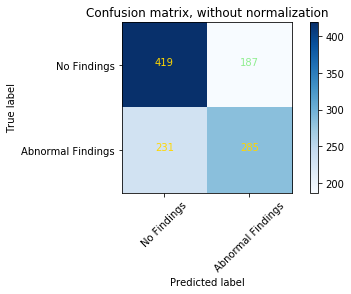

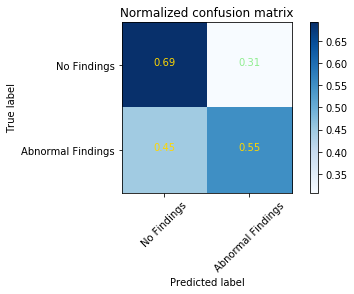

In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

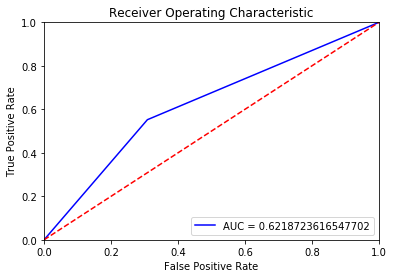

In [29]:
plot_roc(y_test, np.round([p[0] for p in pred_y]))